In [8]:
import matplotlib.pyplot as plt
import os
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import ipytest
import pytest
from climate_index_collection.data_loading import (
    find_data_files,
    load_data_set,
    VARNAME_MAPPING
)
from climate_index_collection.reductions import (
    area_mean_weighted,
    monthly_anomalies_unweighted,
    stddev_unweighted,
)
from climate_index_collection.indices import (
    north_atlantic_oscillation_pc,
    north_atlantic_oscillation,
    southern_annular_mode,
)
from climate_index_collection.data_loading import load_and_preprocess_single_data_file

In [10]:
filepath = os.path.abspath('')

In [2]:
noaa_data = pd.read_csv('1880-2022.csv', header = 4)
noaa_data['time'] = pd.to_datetime(noaa_data['Year'], format='%Y%m',)
noaa_data = noaa_data.set_index('time')
noaa_data = noaa_data.drop("Year", axis=1)
display(noaa_data.std())

FOCI_alldata = load_data_set(data_path="../data/test_data/", data_source_name="FOCI")
CESM_alldata = load_data_set(data_path="../data/test_data/", data_source_name="CESM")

Value    0.44711
dtype: float64

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


As one can see above, the data from NOAA is not standardized.

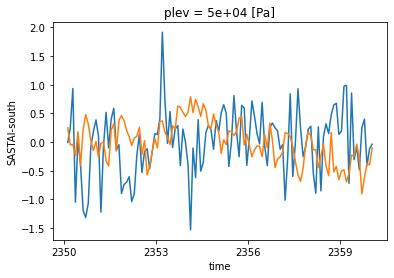

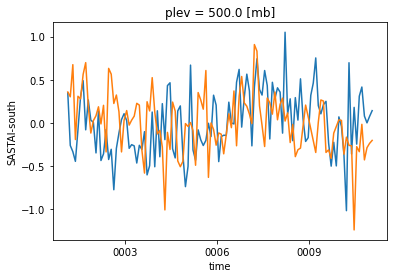

In [3]:
def sea_air_surface_temperature_anomaly_north(data_set, sat_name="sea-air-temperature"):
    """Sea Air Surface Temperature Anomaly (SASTA) index ,
    for the northern hemisphere.
    
    This follows https://www.ncei.noaa.gov/access/monitoring/global-temperature-anomalies/anomalies
    Land and Sea temperature data is used.
    The Anomalies are climatoligical anomalies (monthly) relative to the whole time period of the data_set.
    
    Computation is done as follows:
    1. Compute area averaged total SAT for the hemisphere.
    2. Compute monthly climatology for area averaged SAT for the hemisphere.
    3. Subtract climatology from area averaged total SST time series to obtain anomalies.

    Parameters
    ----------
    data_set: xarray.DataSet
        Dataset containing a SAT field.
    slp_name: str
        Name of the Sea-Air Temperature field. Defaults to "sea-air-temperature".

    Returns
    -------
    xarray.DataArray
        Time series containing the SASTA index for northern hemisphere.

    """
    sea_air_temperature = area_mean_weighted(
        dobj=data_set[sat_name],
        lat_south=0,
        lat_north=90,
        lon_west=0,
        lon_east=360)
    
    sea_air_temp_anom = monthly_anomalies_unweighted(sea_air_temperature)
    SASTAI_North = sea_air_temp_anom.rename("SASTAI-north")

    return SASTAI_North

def sea_air_surface_temperature_anomaly_south(data_set, sat_name="sea-air-temperature"):
    """Sea Air Surface Temperature Anomaly (SASTA) index ,
    for the southern hemisphere.
    
    This follows https://www.ncei.noaa.gov/access/monitoring/global-temperature-anomalies/anomalies
    Land and Sea temperature data is used.
    The Anomalies are climatoligical anomalies (monthly) relative to the whole time period of the data_set.
    
    Computation is done as follows:
    1. Compute area averaged total SAT for the hemisphere.
    2. Compute monthly climatology for area averaged SAT for the hemisphere.
    3. Subtract climatology from area averaged total SST time series to obtain anomalies.

    Parameters
    ----------
    data_set: xarray.DataSet
        Dataset containing a SAT field.
    slp_name: str
        Name of the Sea-Air Temperature field. Defaults to "sea-air-temperature".

    Returns
    -------
    xarray.DataArray
        Time series containing the SASTA index for northern hemisphere.

    """
    sea_air_temperature = area_mean_weighted(
        dobj=data_set[sat_name],
        lat_south=-90,
        lat_north=0,
        lon_west=0,
        lon_east=360)
    
    sea_air_temp_anom = monthly_anomalies_unweighted(sea_air_temperature)
    SASTAI_South = sea_air_temp_anom.rename("SASTAI-south")

    return SASTAI_South

sea_air_surface_temperature_anomaly_north(FOCI_alldata).plot()
sea_air_surface_temperature_anomaly_south(FOCI_alldata).plot()
plt.figure()
sea_air_surface_temperature_anomaly_north(CESM_alldata).plot()
sea_air_surface_temperature_anomaly_south(CESM_alldata).plot()

In [15]:
@pytest.mark.parametrize("source_name", list(VARNAME_MAPPING.keys()))
def test_SASTAI_metadata(source_name):
    """Ensure that index only contains time dimension."""
    # Load test data        
    # TEST_DATA_PATH = Path(__file__).parent / "../data/test_data/"
    TEST_DATA_PATH = filepath + "data/test_data/"
    data_set = load_data_set(data_path=TEST_DATA_PATH, data_source_name=source_name)

    # Calculate SASTAI
    SASTAI_north = sea_air_surface_temperature_anomaly_north(data_set)
    SASTAI_south = sea_air_surface_temperature_anomaly_south(data_set)

    # Check, if calculated SASTAI only has one dimension: 'time'
    # north
    assert SASTAI_north.dims[0] == "time"
    assert len(SASTAI_north.dims) == 1
    # south
    assert SASTAI_south.dims[0] == "time"
    assert len(SASTAI_south.dims) == 1

@pytest.mark.parametrize("source_name", list(VARNAME_MAPPING.keys()))
def test_SASTAI_zeromean(source_name):
    """Ensure that mean of the index is zero."""
    # Load test data
    # TEST_DATA_PATH = Path(__file__).parent / "../data/test_data/"
    TEST_DATA_PATH = filepath + "data/test_data/"
    data_set = load_data_set(data_path=TEST_DATA_PATH, data_source_name=source_name)

    # Calculate SASTAI
    SASTAI_north = sea_air_surface_temperature_anomaly_north(data_set)
    SASTAI_south = sea_air_surface_temperature_anomaly_south(data_set)
    # Check, if calculated SASTAI has zero mean:
    # north
    assert_almost_equal(actual=SASTAI_north.mean("time").values[()], desired=0, decimal=3)
    # south
    assert_almost_equal(actual=SASTAI_south.mean("time").values[()], desired=0, decimal=3)

    
@pytest.mark.parametrize("source_name", list(VARNAME_MAPPING.keys()))
def test_SASTAI_naming(source_name):
    """Ensure that the index is named correctly."""
    # Load test data
    # TEST_DATA_PATH = Path(__file__).parent / "../data/test_data/"
    TEST_DATA_PATH = filepath + "data/test_data/"
    data_set = load_data_set(data_path=TEST_DATA_PATH, data_source_name=source_name)

    # Calculate SASTAI
    SASTAI_north = sea_air_surface_temperature_anomaly_north(data_set)
    SASTAI_south = sea_air_surface_temperature_anomaly_south(data_set)
    
    # north 
    assert SASTAI_north.name == "SASTAI-north"
    # south 
    assert SASTAI_south.name == "SASTAI-south"



In [16]:
ipytest.run()

======================================= test session starts ========================================
platform linux -- Python 3.9.12, pytest-7.1.2, pluggy-1.0.0 -- /srv/conda/envs/notebook/bin/python
cachedir: .pytest_cache
rootdir: /work, configfile: pyproject.toml
plugins: anyio-3.5.0
collecting ... collected 6 items

tmpo5e4wzrw.py::test_SASTAI_metadata[FOCI] FAILED                                            [ 16%]
tmpo5e4wzrw.py::test_SASTAI_metadata[CESM] FAILED                                            [ 33%]
tmpo5e4wzrw.py::test_SASTAI_zeromean[FOCI] FAILED                                            [ 50%]
tmpo5e4wzrw.py::test_SASTAI_zeromean[CESM] FAILED                                            [ 66%]
tmpo5e4wzrw.py::test_SASTAI_naming[FOCI] FAILED                                              [ 83%]
tmpo5e4wzrw.py::test_SASTAI_naming[CESM] FAILED                                              [100%]

============================================= FAILURES ======================

<ExitCode.TESTS_FAILED: 1>